In [ ]:
#Install Libraries

#!pip install numpy
#!pip install pandas
#!pip install sklearn
#!pip install scipy

In [ ]:
#Import Libraries

import csv
import random
import numpy as np
import pandas as pd
import re
import itertools as it
from collections import Counter

# Plotting
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Machine Learning
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from mlxtend.frequent_patterns import apriori, association_rules
from gensim import models,corpora
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.decomposition import LatentDirichletAllocation as LDA
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# read the data file
df = pd.read_csv('metadata.csv')
df.info(verbose=True)
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


# Introduction
According to the news reported from all over the world, COVID is a dangerous virus and it will attack different organs. Even when some patients had recovered from COVID, there are still sequelaes that they need to live with. The purpose of this data analysis task is to explore what organs are more likely to be affected together by COVID and what researches are going on about the organs that are most likely to be affected. Governments, hospitals, and publics can use the insights gained from this analysis to tackle COVID in a better way.

# Data Cleaning
The data cleaning process was performed to make the analysis process easier.  The following processes were used to clean the data: 

*   extracting useful features
*   dropping duplicated rows
*   removing missing values
*   lower casing title and abstract
*   removing special characters from title and abstract but keep '-' (since a lot of medical terminologies have this character)

In [ ]:
# load the meta data from the CSV file and extract out fields that will be useful to our application
df = df[['title','abstract','authors','publish_time']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
df.reset_index(drop=True,inplace=True)
df.head()

,title,abstract,authors,publish_time
0,Clinical features of culture-proven Mycoplasma...,objective: this retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",2001-07-04
1,Nitric oxide: a pro-inflammatory mediator in l...,inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",2000-08-15
2,Surfactant protein-D and pulmonary host defense,surfactant protein-d (sp-d) participates in th...,"Crouch, Erika C",2000-08-25
3,Role of endothelin-1 in lung disease,endothelin-1 (et-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",2001-02-22
4,Gene expression in epithelial cells in respons...,respiratory syncytial virus (rsv) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",2001-05-11


In [ ]:
# lower-casing title
df['title']=df['title'].str.lower()

In [ ]:
# remove special characters (except '-') for title and abstract
df['title']=[re.sub('[^A-Za-z0-9-]+', ' ', title) for title in df['title']]
df['abstract']=[re.sub('[^A-Za-z0-9-]+', ' ', abstract) for abstract in df['abstract']]

In [ ]:
# check data shape
print('There are {} articles being analyzed.'.format(df.shape[0]))

There are 321013 articles being analyzed.


# Feature Extraction 
To better analyze the research papers, there are 7 types of labels that were used to assgin each paper to the corresponding labels (each paper can have multiple labels). The labels are: 
symptoms, affected organs, affected organ systems, 
medical testing and treatment method, COVID related, other virus related, and models that are used to analyze the pandemic. The symptoms, affected organs and organ system were found from the sources below. By assigning labels to each paper, the topic of each paper is more obvious and therefore makes the analysis process more efficient. 

Sources: 

https://www.mayoclinic.org/diseases-conditions/coronavirus/in-depth/coronavirus-long-term-effects/art-20490351
https://www.inquirer.com/health/coronavirus/inq/coronavirus-symptoms-affects-organs-human-body-20200821.html

In [ ]:
# define list of symptoms
symptoms = ['cold', 'fever', 'cough', 'rhinitis', 'sore throat', 'hoarseness', 'bronchitis', 'bronchiolitis',
            'pneumonia', 'shortness of breath','fatigue','pain','diarrhoea','conjunctivitis','headache']
# define affected organs
affect_organs=['heart','lung','brain','blood','vessel','kidney','liver','nervous']
# define system names
system=['pulmonary','respiratory','circulatory','renal','gastrointestinal','immun']
# define testing method, vaccine,treatment 
medical_method=['nucleic acid','rna','vaccine','drug','medicine','treatment']

In [ ]:
# set label for each paper
labels=[]
# iterate through each abstract
for abstract in df['abstract']:
    article_label=[]
    # find symptoms in abstract
    for symptom in symptoms:
        if symptom in abstract:
            article_label.append(symptom)
    # find affected organs in abstract
    for org in affect_organs:
        if org in abstract:
            article_label.append(org)
    # find system in abstract 
    for s in system:
        if s in abstract:
            article_label.append(s)
    # find medical method in abstract
    for medical in medical_method:
        if medical in abstract:
            article_label.append(medical)
    # find coronavirus or coivd in abstract
    if ('coronavirus' in abstract) |('covid' in abstract):
        article_label.append('covid')
    # find other virus in abstract
    if (('virus' in abstract) | ('flu' in abstract)) & ('coronavirus' not in abstract) & ('covid' not in abstract) :
        article_label.append('other virus')
    # find mathematical model in abstract
    if 'model' in abstract:
        article_label.append('model')
    article_label=list(set(article_label))
    labels.append(article_label)

In [ ]:
# add labels column to the dataframe
df['labels']=labels

# Exploratory Data Analysis
The exploratory data analysis is to visualize the data in different plots, charts, etc. to better understand the data and select models for the following analysis. This part includes visualization of :


1.   Number of times each label appears in the data
2.   Number of papers talking about the affected organs and organ system caused by COVID
3.   The percentage of papers about each affected organs or organ system among all organ related topics
4.  The number of papers published before the pandemic and after the pandemic
5.   The wordcloud of frequent words appear in all the titles of research papers that are related to affected organs or organ system



In [ ]:
# count how many times each labels appears
label_count=Counter(it.chain(*map(set,df['labels'])))

In [ ]:
label=[]
count=[]
# extract counts
for l in label_count.keys():
    count.append(label_count[l])
    label.append(l)

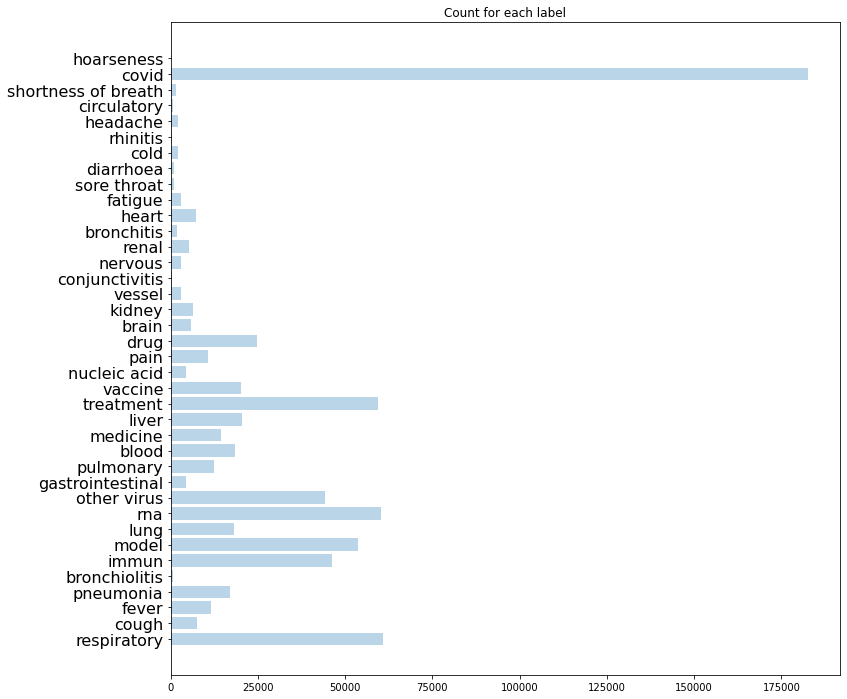

In [ ]:
# plot the count of each label
plt.figure(figsize=(12,12))
plt.barh(label,count,alpha=0.3)
plt.yticks(fontsize=16)
plt.title('Count for each label')
plt.savefig('count for each label')

Insights: A large number of papers have the label 'COVID', therefore this dataset of research papers is helpful to explore COVID related topics. Also, there are a lot papers talking about the affected organs or organ system which can help to investigate which organs will be affected if someone has COVID.

In [ ]:
# count of affected organ or organ system 
organ_related=[]
count=[]
for l in label_count.keys():
    if (l in affect_organs) | (l in system):
        count.append(label_count[l])
        organ_related.append(l)

Text(0.5, 1.0, 'Number of papers about affected organs or organ system')

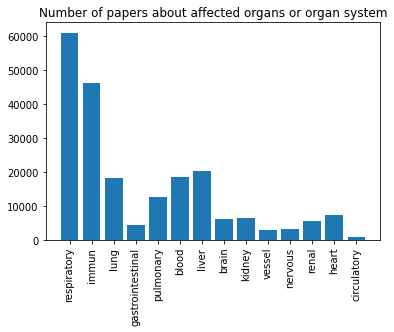

In [ ]:
# bar plot of number of papers about affected organs or organ system
plt.bar(x=organ_related,height=count)
plt.xticks(rotation='vertical')
plt.title('Number of papers about affected organs or organ system')

Insights: A large number of papers with organ related labels are about immunity system and respiratory system, which might indicates that if someone has COVID, the patient will be highly likely to have problems in immunity system and respiratory system.

Text(0.5, 1.0, 'Pie chart of affected organs or organ system')

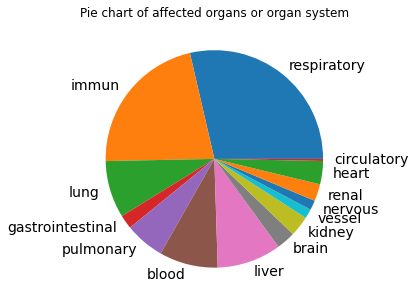

In [ ]:
# create pie chart for affected organs or organ system
plt.figure(figsize=(8,5))
plt.pie(count,labels=organ_related,textprops={'fontsize': 14})
plt.title('Pie chart of affected organs or organ system')

Insights: Among all the affected organs, respiratory system, immunity system, lung, liver and blood are the most commonly discovered affected systems or organs. 

In [ ]:
# compare number of paper published before and after 2020
before_2020=0
after_2020=0
# iterate through each row to count publish year
for y in df['publish_time']:
    if int(y[:4]) < 2020:
        before_2020+=1
    else:
        after_2020+=1

Text(0.5, 1.0, 'Number of published paper before and after the pandemic')

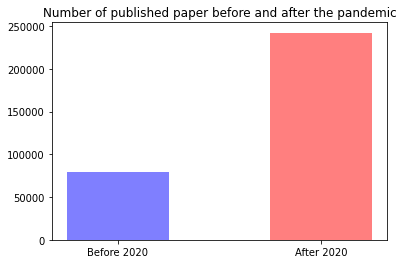

In [ ]:
# plot bar chart to compare publish year
plt.bar(height=[before_2020,after_2020],x=['Before 2020','After 2020'],width=0.5,color=['blue','red'],alpha=0.5)
plt.title('Number of published paper before and after the pandemic')

Insights: By comparing the number of papers published before and after the pandemic, it is obvious that a lot of researches are going on during the pandemic while this research area is less popular before the pandemic. Therefore, most research papers that are being studies in this analysis is effective to COVID-19.

In [ ]:
# find papers related to affected organs or organ system
index=[]
for i in range(df.shape[0]):
    for j in organ_related:
        if j in df['labels'][i]:
            index.append(i)
index=list(set(index))

(-0.5, 3999.5, 2999.5, -0.5)

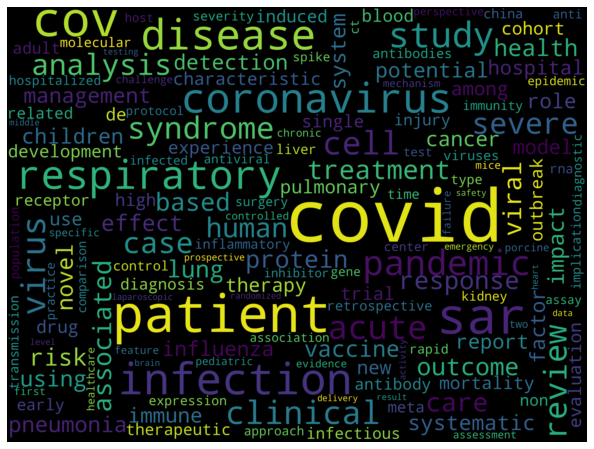

In [ ]:
# create wordcloud for the titles
combined_title=' '.join(df['title'][index])
word_cloud = WordCloud(max_font_size=500,max_words=150,width = 4000, height = 3000,collocations=False).generate(combined_title)
plt.figure(figsize=(15,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')

Insights: From the common words among all the titles, it can tell that coronavirus or COVID is the main subject, while there are some subdivided topics like: detection, diagnosis, evaluation, etc. 

# Model Implementation
The overarching question that I want to investigate is that which organs or systems are more likely to be affected together if someone has COVID and what are the researches going on about the most likely affected organs. The models that I used to explore the questions are: 


*   Hierarchical Clustering
*   KMeans Clustering
*   Association Rule
*   LDA Topic Analysis



## Hierarchical Clustering
The hierarchical clustering uses distance measure to form clusters. Before the distnace measure was calculated, a count matrix was obtained by counting number of times each pair of organs showed in the same paper's label and normalized by the number of times each organ related label showed in the dataset. Then the euclidean distance between each organ was calculated using pairwise distance measure.  After calculating the distance matrix, the result of hierarchical clustering will show which organs or systems are grouped together and therefore it demonstrates which organs or systems are more likely to be attacked by COVID together. 

In [ ]:
#define matrix
organ_count = np.zeros((len(organ_related),len(organ_related)), dtype=float)
# count number of times each pair of organs appear in the same paper's label
for l in df['labels']:
    for i in range(len(organ_related)):
        for j in range(len(organ_related)):
            if (organ_related[i] in l) & (organ_related[j] in l):
                organ_count[i][j]+=1

In [ ]:
# normalize the count by number of times each label appears
for i in range(len(organ_related)):
    organ_count[i]=organ_count[i]/organ_count[i,i]

In [ ]:
# calculate euclidean distance
organ_dist=pairwise_distances(organ_count,metric='euclidean')

In [ ]:
# create a dataframe with the distance matrix
df_organs = pd.DataFrame(organ_dist, columns=organ_related, index=organ_related)

In [ ]:
# perform hierarchical clustering
Y = sch.linkage(organ_dist, method='single')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


Text(0.5, 1.0, 'Affected organs or systems clusters')

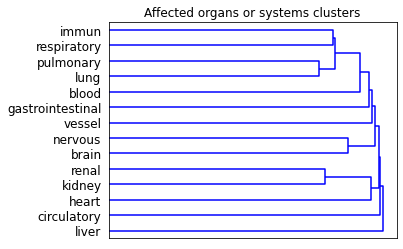

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_axes([0.1,0.1,0.4,0.6])
ax1.set_xticks([])
# Get the dendrogram
Z1 = sch.dendrogram(Y, orientation='right')
labels = df_organs.columns[Z1['leaves']]
ax1.set_yticklabels(labels)
ax1.set_title("Affected organs or systems clusters")

Insight: The dendrogram shows that respiratory system and immunity system, pulmonary system and lung, renal system and kidney, nervous system and brain are more likely to be affected together. 

## KMeans Clustering
The KMeans clustering model is used to group affected organs or systems with similar symptoms together. In contrast to the distance measure used in hierarchical clustering, the KMeans model directly uses organ-symptom matrix with absolute count of each pair normalized by the sum of each row.  In this way, each organ or system is a sample and the symptoms are the features, the KMeans clustering model will iteratively reduce the within-cluster variance and therefore group the affected organs or systems with similar symptoms together. From the dendrogram, there are 5 major clusters, so the k value was set to be 5 for KMeans clustering. 

In [ ]:
#define absolute count matrix between symptoms and affected organs 
symptom_organ_count=np.zeros((len(organ_related),len(symptoms)), dtype=float)

In [ ]:
# iterate through each paper's label to find how many times each symptoms is mentioned with each affected organs
for l in df['labels']:
    for i in range(len(organ_related)):
        for j in range(len(symptoms)):
            if (organ_related[i] in l) & (symptoms[j] in l):
                symptom_organ_count[i][j]+=1

In [ ]:
# normalize the absolute distance matrix 
symptom_organ_dist=symptom_organ_count/symptom_organ_count.sum(axis=1,keepdims=True)

In [ ]:
# create a dataframe
df_symptom_organs = pd.DataFrame(symptom_organ_dist, columns=symptoms, index=organ_related)

In [ ]:
# fit KMeans cluster
kmeans = KMeans(n_clusters=5, random_state=0).fit(symptom_organ_dist)

In [ ]:
# get the cluster label of each affected organs
cluster_labels=kmeans.labels_

In [ ]:
# assign each affected organ to a label
cluster_dict={'class 1':[],'class 2':[],'class 3':[],'class 4':[],'class 5':[]}
for i in range(len(organ_related)):
    for j in range(5):
        if cluster_labels[i] == j:
            cluster_dict['class {}'.format(j+1)].append(organ_related[i])

In [ ]:
# print cluster result
for i in range(5):
    print('Class {} of affected organs with similar symptoms: '.format(i+1))
    print(cluster_dict['class {}'.format(i+1)])

Class 1 of affected organs with similar symptoms: 
['blood', 'liver', 'kidney', 'vessel', 'renal', 'heart']
Class 2 of affected organs with similar symptoms: 
['lung', 'pulmonary']
Class 3 of affected organs with similar symptoms: 
['brain', 'nervous']
Class 4 of affected organs with similar symptoms: 
['gastrointestinal']
Class 5 of affected organs with similar symptoms: 
['respiratory', 'immun', 'circulatory']


In [ ]:
# visualy present the result
centroid_x=[0,5,10,15,25]
centroid_y=[2,12,22,2,8]
coordinate_x=[]
coordinate_y=[]
for i in range(5):
    for k in cluster_dict['class {}'.format(i+1)]:
        coordinate_x.append(centroid_x[i]+np.random.normal(0,2))
        coordinate_y.append(centroid_y[i]+np.random.normal(0,2))

Text(0.5, 1.0, 'Visualization of affected organs clustering')

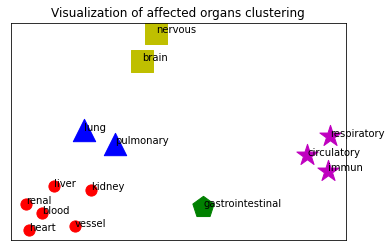

In [ ]:
fig, ax = plt.subplots()
for i in range(len(organ_related)):
    if i < 6:
        ax.scatter(coordinate_x[i],coordinate_y[i],c='r',marker='.',s=500)
        ax.annotate(cluster_dict['class 1'][i], (coordinate_x[i],coordinate_y[i]))
    elif (i >= 6) & (i < 8):
        ax.scatter(coordinate_x[i],coordinate_y[i],c='b',marker='^',s=500)
        ax.annotate(cluster_dict['class 2'][i-6], (coordinate_x[i],coordinate_y[i]))
    elif (i >=8) & (i < 10):
        ax.scatter(coordinate_x[i],coordinate_y[i],c='y',marker='s',s=500)
        ax.annotate(cluster_dict['class 3'][i-8], (coordinate_x[i],coordinate_y[i]))
    elif (i >= 10) & (i < 11):
        ax.scatter(coordinate_x[i],coordinate_y[i],c='g',marker='p',s=500)
        ax.annotate(cluster_dict['class 4'][i-10], (coordinate_x[i],coordinate_y[i]))
    else:
        ax.scatter(coordinate_x[i],coordinate_y[i],c='m',marker='*',s=500)
        ax.annotate(cluster_dict['class 5'][i-11], (coordinate_x[i],coordinate_y[i]))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Visualization of affected organs clustering')

**Note: the plot above is just a demonstration of the clusters, the actual distance between each point is different from this.**

Insights: The result of KMeans clustering shows that the affected organs or systems with similar symptoms are:


1.   blood, liver, kidney, vessel, renal system, heart
2.   lung, pulmonary system
3.   brain, nervous system
4.   gastrointestinal system
5.   immunity system, respiratory system, circulatory system



## Association Rule: Apriori
The association rule is a method to identify underlying relations between items and Apriori is one application of it. There are three major components of Apriori algorithm: Support, Confidence and Lift. Suppose there is a dataframe where each row corresponds to a paper and each column corresponds to an organ related label. Support indicates the popularity of an item, which can be calculated using: number of rows contains item/total number of rows. Confidence shows the likelihood that when item A shows, item B shows in the same row as well, which can be calculated using: number of rows with A and B/number of rows with A. Lift shows how much more that item B appears if item A appears, which can be calcualted using: Confidence(A-B)/Support(B). Using the Apriori algorithm, the relations between affected organs will be displayed in a more statistical way. This time the matrix that are being used is a matrix that only contains binary values that indicates if the organ appears in each paper's labels.


In [ ]:
# create a matrix contains binary value of appearance of each affected organs 
organ_appearance=np.zeros((len(df),len(organ_related)), dtype=float)

In [ ]:
# if the affected organ appears in a paper put 1 in the corresponding entry
for i in range(organ_appearance.shape[0]):
    for j in range(organ_appearance.shape[1]):
        if organ_related[j] in df['labels'][i]:
            organ_appearance[i][j] =1 

In [ ]:
# create a dataframe using the appearance of affected organ
df_organ_appearance=pd.DataFrame(organ_appearance,columns=organ_related)

In [ ]:
# use apriori model to find frequent items
freq_items = apriori(df_organ_appearance, min_support=0.01,use_colnames=True)

In [ ]:
# get the association rules with threshold of confidence equals 0.3
rules = association_rules(freq_items, metric="confidence", min_threshold=0.2)

In [ ]:
# display the association rules
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(immun),(respiratory),0.143935,0.189724,0.044518,0.309296,1.630236,0.017210,1.173115
1,(respiratory),(immun),0.189724,0.143935,0.044518,0.234648,1.630236,0.017210,1.118525
2,(lung),(respiratory),0.056322,0.189724,0.026513,0.470741,2.481184,0.015827,1.530963
3,(pulmonary),(respiratory),0.039067,0.189724,0.017943,0.459294,2.420846,0.010531,1.498550
4,(blood),(respiratory),0.057792,0.189724,0.014856,0.257061,1.354919,0.003892,1.090636
5,(lung),(immun),0.056322,0.143935,0.015784,0.280254,1.947090,0.007678,1.189399
6,(blood),(immun),0.057792,0.143935,0.015140,0.261966,1.820033,0.006821,1.159927
7,(pulmonary),(lung),0.039067,0.056322,0.014264,0.365122,6.482801,0.012064,1.486394
8,(lung),(pulmonary),0.056322,0.039067,0.014264,0.253263,6.482801,0.012064,1.286843


Insights: The result shows that with confidence greater than 20%, immunity system and blood will have more than 20% chance to get affected with the major affected organ or system (lung, respiratory system, etc). 

## LDA Topic Analysis
From the above analysis, it is obvious that lung and respiratory sytem are the most commonly affected by COVID. Therefore, by applying LDA to the abstract of research papers related to these two topics, we can get some insights on how the researches were performed about these organ systems and what are the research papers studying about these systems. 

The Linear Discriminant Analysis algorithm will find new axes based on the number passes to the functions and project each feature to the new axes. Before using LDA model to find topics, the abstract of each paper was vectroized using TF-IDF vectorizer and removed stopwords using NLTK's default stopwords. After fitting the LDA model with the vectorized feature, the 10 most important features of each component will be found and encoded back to each word.

In [ ]:
# find papers related to lung or respiratory system
index=[]
for i in range(df.shape[0]):
    if ('lung' in df['labels'][i]) | ('respiratory' in df['labels'][i]):
        index.append(i)

In [ ]:
# get the subset of dataframe
topic_df=df.iloc[index,:]

In [ ]:
# vectorize the abstract text
my_stopwords=stopwords.words('english')
vectorizer=TfidfVectorizer(max_features=1000,stop_words=my_stopwords)
tf_idf_abstract=vectorizer.fit_transform(topic_df['abstract'])

In [ ]:
# fit the model
lda = LDA(n_components=3)
lda.fit(tf_idf_abstract)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=3, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [ ]:
# print top 10 keywords for each abstract
for i in range(3):
    print("==========")
    print('Keywords for topic {}:'.format(i+1))
    top_10=np.argsort(lda.components_[i])[:10]
    for j in range(10):
        print('{}'.format(vectorizer.get_feature_names()[top_10[j]]))

Keywords for topic 1:
prrsv
rbd
signaling
ace2
protease
genome
spike
sequences
binding
proteins
Keywords for topic 2:
ecmo
storm
ace2
angiotensin
signaling
oxygenation
ards
obesity
cytokine
hypertension
Keywords for topic 3:
iqr
hcws
ci
median
enrolled
logistic
ecmo
swab
95
discharged


Insights: The keywords of the first topic: signaling, protease, genome, etc. might indicate that the first topic is about the researches that are going on about the disease. The keywords of the second topic: Extracorporeal membrane oxygenation (ECMO), oxygenation, obesity, hypertension, etc. might indicates that COVID-19 is a very dangerous virus and patients with COIVD-19 need to get emergency medical treatment and people with obesity and hypertension need to be more careful about COVID-19. The keywords of the third topic shows that swab might be the main testing method for COVID-19 right now, and the word 'discharged' indicates that COVID-19 is curable. 

# Insights about policy and guidance to tackle the outbreak based on model findings



*   Lung, pulmonary system and respiratory system are more likely to be affected and affected together if someone has COVID. Therefore, people with historical pulmonary system or lung diseases should be more cautious about COVID. Policies can be made to give people with history of lung disease  priority of getting vaccine. 
*   Immunity system, respiratory system and circulatory system are also very likely to be affected together for patients with COVID, therefore the hospital should be ready on treating the failure of these systems. For example, getting more equipment, assigning more specialists in these areas to each hospital, etc. 
*   Organs with more likelihood of being affected together will have similar symptoms, therefore doctors need to test the functionality of other organs when treating the patients. 
*   COVID is a dangerous virus, with the affected lung or respirotory system, the patient will need to get urgent medical treatment. Governments need to help hospitals to get more medical equipments to increase the survival rate. 

